In [45]:
import pandas as pd
import numpy as np
import pyarrow
import nfl_data_py as nfl

In [35]:
# read files of raw data from regular season
bbm3_reg_season=[]
for i in range(9):
    print("reading files from group " + str(i))
    try:
        bbm3_reg_season.append(pd.read_csv("https://raw.githubusercontent.com/fantasydatapros/best-ball-data-bowl/master/data/2022/regular_season/fast/part_0" + str(i+1) + ".csv"))
        time.sleep(1)
    except:
        print("failed fast " + str(i))
        pass
    try:
        bbm3_reg_season.append(pd.read_csv("https://raw.githubusercontent.com/fantasydatapros/best-ball-data-bowl/master/data/2022/regular_season/mixed/part_0" + str(i+1) + ".csv"))
        time.sleep(1)
    except:
        print("failed mixed " + str(i))
        pass

for j in range(9,27):
    print("reading files from group " + str(j))
    try:
        if j < 10:
            fnum = "0" + str(j)
        else:
            fnum = str(j)
        bbm3_reg_season.append(pd.read_csv("https://raw.githubusercontent.com/fantasydatapros/best-ball-data-bowl/master/data/2022/regular_season/fast/part_" + fnum + ".csv"))
        time.sleep(1)
    except:
        print("failed fast " + str(j))
        pass
    
bbm3_reg_season = pd.concat(bbm3_reg_season)

# keep data only for draft_id values with 216 picks (data might be spread across other files not used here or missing entirely)
draft_ids_to_keep = bbm3_reg_season['draft_id'].value_counts()
draft_ids_to_keep = draft_ids_to_keep[draft_ids_to_keep == 216].index.values
bbm3_reg_season = bbm3_reg_season[bbm3_reg_season['draft_id'].isin(draft_ids_to_keep)].sort_values(['draft_id','overall_pick_number']).reset_index(drop=True)

In [36]:
# identify which teams advanced to quarterfinals based on top two scores in each draft
teams_adv_to_qtr = bbm3_reg_season[['draft_id','tournament_entry_id','roster_points']].drop_duplicates() \
    .groupby('draft_id').apply(lambda group: group.nlargest(2, "roster_points")).reset_index(drop=True)

# add identifier to original data frame if the team advanced
bbm3_reg_season['adv_to_qtr'] = np.where(bbm3_reg_season['tournament_entry_id'].isin(teams_adv_to_qtr['tournament_entry_id']), 1., 0.)

In [38]:
# calculate number of each position already taken at each pick in their respective draft
cumu_gone_pos = pd.DataFrame(bbm3_reg_season['draft_id'])
cumu_gone_pos['cumu_QB_gone'] = bbm3_reg_season[bbm3_reg_season['position_name'] == "QB"].groupby("draft_id").cumcount()
cumu_gone_pos['cumu_RB_gone'] = bbm3_reg_season[bbm3_reg_season['position_name'] == "RB"].groupby("draft_id").cumcount()
cumu_gone_pos['cumu_WR_gone'] = bbm3_reg_season[bbm3_reg_season['position_name'] == "WR"].groupby("draft_id").cumcount()
cumu_gone_pos['cumu_TE_gone'] = bbm3_reg_season[bbm3_reg_season['position_name'] == "TE"].groupby("draft_id").cumcount()
cumu_gone_pos = cumu_gone_pos.groupby("draft_id")[['cumu_QB_gone','cumu_RB_gone','cumu_WR_gone','cumu_TE_gone']].bfill().ffill()
bbm3_reg_season = pd.concat([bbm3_reg_season, cumu_gone_pos], axis=1)
bbm3_reg_season[['cumu_QB_gone','cumu_RB_gone','cumu_WR_gone','cumu_TE_gone']] = bbm3_reg_season[['cumu_QB_gone','cumu_RB_gone','cumu_WR_gone','cumu_TE_gone']].fillna(0)

In [56]:
# query weekly player stats and add UD fantasy points column
nfl_weekly_2022 = nfl.import_weekly_data(years=[2022])
nfl_weekly_2022['fpts'] = nfl_weekly_2022.apply(lambda row: row['receptions']*0.5 + row['receiving_tds']*6.0 + row['receiving_yards']*0.1 + row['rushing_tds']*6.0 + row['rushing_yards']*0.1 + row['passing_yards']*0.04 + row['passing_tds']*4.0 + row['interceptions']*-1.0 + row['passing_2pt_conversions']*2.0 + row['rushing_2pt_conversions']*2.0 + row['receiving_2pt_conversions']*2.0 + row['sack_fumbles_lost']*-2.0 + row['rushing_fumbles_lost']*-2.0 + row['receiving_fumbles_lost']*-2.0, axis=1)

Downcasting floats.


In [83]:
# fix a few name mismatches between BBM files and weekly stats
nfl_weekly_2022.loc[nfl_weekly_2022['player_display_name'] == "DJ Moore", 'player_display_name'] = 'D.J. Moore'
nfl_weekly_2022.loc[nfl_weekly_2022['player_display_name'] == "AJ Dillon", 'player_display_name'] = 'A.J. Dillon'
nfl_weekly_2022.loc[nfl_weekly_2022['player_display_name'] == "Joshua Palmer", 'player_display_name'] = 'Josh Palmer'
nfl_weekly_2022.loc[nfl_weekly_2022['player_display_name'] == "DJ Chark", 'player_display_name'] = 'D.J. Chark'
nfl_weekly_2022.loc[nfl_weekly_2022['player_display_name'] == "KJ Hamler", 'player_display_name'] = 'K.J. Hamler'
nfl_weekly_2022.loc[nfl_weekly_2022['player_display_name'] == "Robbie Anderson", 'player_display_name'] = 'Robbie Anderson'
nfl_weekly_2022.loc[nfl_weekly_2022['player_display_name'] == "Jeff Wilson", 'player_display_name'] = 'Jeff Wilson'
nfl_weekly_2022.loc[nfl_weekly_2022['player_display_name'] == "Mike Davis", 'player_display_name'] = 'Mike Davis'
# some other names in BBM files aren't found in nfl weekly data, but didn't play and had no weekly stats

In [96]:
# calculate ADP for each player

# replace FB with RB
bbm3_reg_season.loc[bbm3_reg_season['position_name'] == "FB", "position_name"] = 'RB'

# only keep players drafted 20+ times (ex. Davis Webb was drafted just once and it was at 1.06)
players_to_keep = bbm3_reg_season['player_name'][bbm3_reg_season['player_name'].map(bbm3_reg_season['player_name'].value_counts()) >= 20]

bbm3_adp = bbm3_reg_season[bbm3_reg_season['player_name'].isin(players_to_keep)]\
    .groupby(['player_name','position_name'])['overall_pick_number'].mean().reset_index()\
    .sort_values(['position_name','overall_pick_number'])\
    .rename(columns={'overall_pick_number': 'adp'})\
    .reset_index(drop=True)

,player_name,position_name,adp
0,Josh Allen,QB,29.317713
1,Justin Herbert,QB,43.955080
2,Patrick Mahomes,QB,47.234335
3,Lamar Jackson,QB,48.033830
4,Kyler Murray,QB,60.507261
...,...,...,...
405,Lynn Bowden,WR,207.650000
406,Tylan Wallace,WR,208.202276
407,Tyron Johnson,WR,208.428571
408,John Ross,WR,208.615385


In [213]:
# create function to return player names of most similar players by ADP
def get_similar_players_for_lineup(players, positions, n_similar_players=8):
    # if player not found in ADP, replace ADP with 215
    output=[]
    for i in range(len(players)):
        same_pos_adp = bbm3_adp.loc[bbm3_adp['position_name'] == positions[i],:]
        adp_of_player = bbm3_adp.loc[bbm3_adp['player_name'] == players[i], 'adp'].values
        if len(adp_of_player) == 0:
            adp_of_player = np.array(215)
        same_pos_adp = same_pos_adp.assign(dist = np.abs(same_pos_adp['adp'].values - adp_of_player))
        output.append(np.random.choice(same_pos_adp['player_name'][same_pos_adp.nsmallest(n_similar_players, 'dist').index].values))
    return output


In [264]:
# create function to identify which players' scores will count towards the weekly total for a given team
def get_roster_fpts_for_week(week_player_pts_df):
    idx_QB = week_player_pts_df[(week_player_pts_df['position_group'] == "QB")].sort_values('fpts', ascending=False).head(1).index.values
    idx_RB = week_player_pts_df[(week_player_pts_df['position_group'] == "RB")].sort_values('fpts', ascending=False).head(2).index.values
    idx_WR = week_player_pts_df[(week_player_pts_df['position_group'] == "WR")].sort_values('fpts', ascending=False).head(3).index.values
    idx_TE = week_player_pts_df[(week_player_pts_df['position_group'] == "TE")].sort_values('fpts', ascending=False).head(1).index.values
    idx_FLEX = week_player_pts_df[(week_player_pts_df['position_group'] != "QB") & (~week_player_pts_df.index.isin(idx_RB)) & (~week_player_pts_df.index.isin(idx_WR)) & (~week_player_pts_df.index.isin(idx_TE))].sort_values('fpts', ascending=False).head(1).index.values
    return np.sum(week_player_pts_df.loc[np.concatenate([idx_QB, idx_RB, idx_WR, idx_TE, idx_FLEX]),'fpts'].values)

# simulate the total regular season roster score of an entry based on similar players
def sim_entry_on_similar_players(entry_to_use):
    entry_actual_players = bbm3_reg_season[bbm3_reg_season['tournament_entry_id'] == entry_to_use]['player_name'].values
    entry_actual_positions = bbm3_reg_season[bbm3_reg_season['tournament_entry_id'] == entry_to_use]['position_name'].values
    players_for_sim = get_similar_players_for_lineup(entry_actual_players, entry_actual_positions)
    weekly_outcomes = nfl_weekly_2022[(nfl_weekly_2022['player_display_name'].isin(players_for_sim)) & (nfl_weekly_2022['week'] <= 14)][['week','position_group','fpts']]
    weekly_outcomes.loc[weekly_outcomes['position_group'] == "FB", "position_group"] = 'RB'
    weekly_roster_score = []
    for i in range(14):
        weekly_roster_score.append(get_roster_fpts_for_week(weekly_outcomes[weekly_outcomes['week']==i+1]))
    return np.sum(weekly_roster_score)


In [275]:
unique_entry_ids = np.unique(bbm3_reg_season['tournament_entry_id'].values)
entry_sim_roster_scores=[None] * len(unique_entry_ids)
# for entry_idx in range(len(unique_entry_ids)):
for entry_idx in range(10):
    print('running ' + str(entry_idx+1))
    entry_sim_roster_scores[entry_idx] = sim_entry_on_similar_players(unique_entry_ids[entry_idx])

running 1
running 2
running 3
running 4
running 5
running 6
running 7
running 8
running 9
running 10


In [283]:
# completed 451,200 iterations in 5:34 with 24 available cores

import multiprocessing
from tqdm import tqdm

num_cores = multiprocessing.cpu_count()
print("Number of CPU cores:", num_cores)

def process_entry(entry_idx):
    return sim_entry_on_similar_players(unique_entry_ids[entry_idx])

if __name__ == '__main__':
    # set number of iterations
    n_iterations = len(unique_entry_ids)

    # create pool for iterations
    pool = multiprocessing.Pool()

    # create a progress bar
    with tqdm(total=n_iterations, desc="Progress") as pbar:
        results=[]
        for result in pool.imap(process_entry, range(n_iterations)):
            results.append(result)
            # update progress bar
            pbar.update()

    pool.close()
    pool.join()

    print('results are now complete in the "results" list')


Number of CPU cores: 24


Progress: 100%|██████████| 451200/451200 [5:34:10<00:00, 22.50it/s]   


results are now complete in the "entry_sim_roster_scores" list


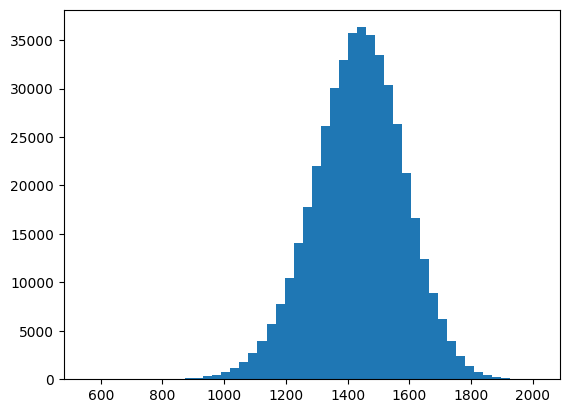

In [289]:
import matplotlib.pyplot as plt
plt.hist(results, bins=50);

In [294]:
# create dataframe of simmed scores and merge to create bbm3_sim
simmed_roster_scores = pd.DataFrame({
    'tournament_entry_id' : unique_entry_ids,
    'simmed_roster_score' : results
})

bbm3_sim = pd.merge(bbm3_reg_season, simmed_roster_scores, how='left', on='tournament_entry_id')

# add identifier of which teams advanced to quarterfinals (top 2 teams per draft_id)
simmed_teams_adv_to_qtr = bbm3_sim[['draft_id','tournament_entry_id','simmed_roster_score']].drop_duplicates() \
    .groupby('draft_id').apply(lambda group: group.nlargest(2, "simmed_roster_score")).reset_index(drop=True)

# add identifier to original data frame if the team advanced
bbm3_sim['adv_in_sim'] = np.where(bbm3_sim['tournament_entry_id'].isin(simmed_teams_adv_to_qtr['tournament_entry_id']), 1., 0.)

In [297]:
# write parquet file
bbm3_sim.to_parquet('bbm3_sim.parquet', engine='pyarrow', compression='gzip')